<a href="https://colab.research.google.com/github/JonathanNdambaPro/Regression/blob/master/House_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyse Type pour Data Scientist et ou Data Analyst par Jonathan Ndamba. 
## (niveau: moyen - eleve)

## Etudes des differents differents prix de vente de differrents biens immobiliers au Etats-unis

Ce notebook a pour but de donnees une methodologie d'analyse d'un jeu de donnees a toute personne qui en aurait besoin, il peut etre utilise par toute personne qui le souhaite, si quelqu'un voudrais echanger ou apporter un autre point de vue peut me contacter sur mon mail

Merci de vous referer du notebook Google Colab(Les graphiques Plotly ne s'afficheront pas sinon)

Mail : jonathan.ndamba.pro@gmail.com


In [25]:
!pip install eli5
!pip install pdpbox
!pip install shap
!pip install lightgbm --upgrade
!pip install hyperopt --upgrade
!pip install plotly --upgrade
!pip install mlxtend --upgrade

from mlxtend.data import iris_data
from mlxtend.plotting import plot_pca_correlation_graph
import numpy as np
from sklearn.metrics import r2_score as R2
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import lightgbm as lgb
import pandas as pd
import os
import seaborn as sns 
import matplotlib.pyplot as plt
import gc
import seaborn as sns
import warnings
import numpy as np 
import plotly
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import KBinsDiscretizer

from typing import List, Dict, Tuple

warnings.filterwarnings("ignore")

from google.colab import drive
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


from sklearn.tree import DecisionTreeClassifier
import eli5
from eli5.sklearn import PermutationImportance
from sklearn import tree
import graphviz
import shap
import lightgbm



drive.mount('/content/drive')

os.chdir('/content/drive/My Drive/House Prediction')
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_data.YrSold = train_data.YrSold.astype('int64')
train_data.OverallCond = train_data.OverallCond.astype('int64')
train_data.YearRemodAdd = train_data.YearRemodAdd.astype('int64')
train_data.YearBuilt = train_data.YearBuilt.astype('int64')
train_data.GarageYrBlt = train_data.GarageYrBlt.astype('float')

train_data = train_data.drop('Id', axis=1)

Requirement already up-to-date: lightgbm in /usr/local/lib/python3.6/dist-packages (2.3.1)
Requirement already up-to-date: hyperopt in /usr/local/lib/python3.6/dist-packages (0.2.4)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.8.2)
Requirement already up-to-date: mlxtend in /usr/local/lib/python3.6/dist-packages (0.17.2)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
def plotting_cat_Target(columns: List[str], name: str, Verbose: bool, figsize=(15,15), size = (20, 10)) -> None:
  fig, axes = plt.subplots(nrows=1, ncols=2)
  sns.set(rc={'figure.figsize':figsize})
  train_data_cat[columns].value_counts().plot.bar(figsize=size, title="{} : count".format(columns), ax=axes[0])
  df = pd.pivot_table(train_data, values=target, index=columns, aggfunc=['mean', 'std', len, 'median'])
  df.columns = ['/'.join(w) for w in df.columns]
  df.sort_values(by=name, ascending=False).plot.bar(ax=axes[1], title="{} : mean & std".format(columns), figsize=size)
  plt.show()
  ax = sns.violinplot(x=columns, y=target, data=train_data)
  plt.show()
  if Verbose:
    print(df.sort_values(by=name, ascending=False))
  else: pass

def multicolinearity_dectection(corr: pd.DataFrame, seuil: float) -> List:
  """
  Prend en entrer une matrice de correlation et retourne une liste de tuple des variables tres correlee
  corr: pd.DataFrame
  seuil: float
  rtype: List[tuple]
  """
  columns_corr = corr.columns
  multicolinearity = []
  for col in columns_corr:
    corr_var = corr[col][corr[col] > seuil].index
    multicolinearity += [(col, w) for w in corr_var if w != col and (w, col) not in multicolinearity]

  return multicolinearity

def plotting_num_dist(columns: str, data: pd.DataFrame, figsize=(10,10)) -> None:
  sns.set(rc={'figure.figsize':figsize})
  x = data[columns]
  sns.distplot(x)
  plt.show()

def plotting_num_join(columns: str, data: pd.DataFrame, figsize=(10,10)) -> None:
  sns.set(rc={'figure.figsize':figsize})
  g = sns.jointplot(target, col, data=data,
                    kind="reg", space=0,
                    color="g", size=10)
  plt.show()

def hyperopt_train_test(params: Dict, X: pd.DataFrame, Y: pd.DataFrame) -> float:
  clf = lgb.LGBMRegressor(**params)
  scores = cross_val_score(clf, X, Y, cv=5, n_jobs=-1, scoring='r2')
  neg_R2_mean = -scores.mean()
  return neg_R2_mean

def plot_time(target: str, Year:str) -> None:
  df = train_data.groupby(by=Year).mean().SalePrice.reset_index()
  fig = px.line(df, y=target, x=Year)
  fig.show()



## Data Description

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density
	
LotFrontage: Linear feet of street connected to property

LotArea: Lot size in square feet

Street: Type of road access to property

       Grvl	Gravel	
       Pave	Paved
       	
Alley: Type of alley access to property

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access
		
LotShape: General shape of property

       Reg	Regular	
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular
       
LandContour: Flatness of the property

       Lvl	Near Flat/Level	
       Bnk	Banked - Quick and significant rise from street grade to building
       HLS	Hillside - Significant slope from side to side
       Low	Depression
		
Utilities: Type of utilities available
		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only	
	
LotConfig: Lot configuration

       Inside	Inside lot
       Corner	Corner lot
       CulDSac	Cul-de-sac
       FR2	Frontage on 2 sides of property
       FR3	Frontage on 3 sides of property
	
LandSlope: Slope of property
		
       Gtl	Gentle slope
       Mod	Moderate Slope	
       Sev	Severe Slope
	
Neighborhood: Physical locations within Ames city limits

       Blmngtn	Bloomington Heights
       Blueste	Bluestem
       BrDale	Briardale
       BrkSide	Brookside
       ClearCr	Clear Creek
       CollgCr	College Creek
       Crawfor	Crawford
       Edwards	Edwards
       Gilbert	Gilbert
       IDOTRR	Iowa DOT and Rail Road
       MeadowV	Meadow Village
       Mitchel	Mitchell
       Names	North Ames
       NoRidge	Northridge
       NPkVill	Northpark Villa
       NridgHt	Northridge Heights
       NWAmes	Northwest Ames
       OldTown	Old Town
       SWISU	South & West of Iowa State University
       Sawyer	Sawyer
       SawyerW	Sawyer West
       Somerst	Somerset
       StoneBr	Stone Brook
       Timber	Timberland
       Veenker	Veenker
			
Condition1: Proximity to various conditions
	
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
	
Condition2: Proximity to various conditions (if more than one is present)
		
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
	
BldgType: Type of dwelling
		
       1Fam	Single-family Detached	
       2FmCon	Two-family Conversion; originally built as one-family dwelling
       Duplx	Duplex
       TwnhsE	Townhouse End Unit
       TwnhsI	Townhouse Inside Unit
	
HouseStyle: Style of dwelling
	
       1Story	One story
       1.5Fin	One and one-half story: 2nd level finished
       1.5Unf	One and one-half story: 2nd level unfinished
       2Story	Two story
       2.5Fin	Two and one-half story: 2nd level finished
       2.5Unf	Two and one-half story: 2nd level unfinished
       SFoyer	Split Foyer
       SLvl	Split Level
	
OverallQual: Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor
	
OverallCond: Rates the overall condition of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average	
       5	Average
       4	Below Average	
       3	Fair
       2	Poor
       1	Very Poor
		
YearBuilt: Original construction date

YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)

RoofStyle: Type of roof

       Flat	Flat
       Gable	Gable
       Gambrel	Gabrel (Barn)
       Hip	Hip
       Mansard	Mansard
       Shed	Shed
		
RoofMatl: Roof material

       ClyTile	Clay or Tile
       CompShg	Standard (Composite) Shingle
       Membran	Membrane
       Metal	Metal
       Roll	Roll
       Tar&Grv	Gravel & Tar
       WdShake	Wood Shakes
       WdShngl	Wood Shingles
		
Exterior1st: Exterior covering on house

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast	
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
	
Exterior2nd: Exterior covering on house (if more than one material)

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
	
MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone
	
MasVnrArea: Masonry veneer area in square feet

ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
ExterCond: Evaluates the present condition of the material on the exterior
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
Foundation: Type of foundation
		
       BrkTil	Brick & Tile
       CBlock	Cinder Block
       PConc	Poured Contrete	
       Slab	Slab
       Stone	Stone
       Wood	Wood
		
BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
		
BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
	
BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
	
BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
		
BsmtFinSF1: Type 1 finished square feet

BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

BsmtFinSF2: Type 2 finished square feet

BsmtUnfSF: Unfinished square feet of basement area

TotalBsmtSF: Total square feet of basement area

Heating: Type of heating
		
       Floor	Floor Furnace
       GasA	Gas forced warm air furnace
       GasW	Gas hot water or steam heat
       Grav	Gravity furnace	
       OthW	Hot water or steam heat other than gas
       Wall	Wall furnace
		
HeatingQC: Heating quality and condition

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
CentralAir: Central air conditioning

       N	No
       Y	Yes
		
Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed
		
1stFlrSF: First Floor square feet
 
2ndFlrSF: Second floor square feet

LowQualFinSF: Low quality finished square feet (all floors)

GrLivArea: Above grade (ground) living area square feet

BsmtFullBath: Basement full bathrooms

BsmtHalfBath: Basement half bathrooms

FullBath: Full bathrooms above grade

HalfBath: Half baths above grade

Bedroom: Bedrooms above grade (does NOT include basement bedrooms)

Kitchen: Kitchens above grade

KitchenQual: Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       	
TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)

Functional: Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only
		
Fireplaces: Number of fireplaces

FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace
		
GarageType: Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage
		
GarageYrBlt: Year garage was built
		
GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage
		
GarageCars: Size of garage in car capacity

GarageArea: Size of garage in square feet

GarageQual: Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		
GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		
PavedDrive: Paved driveway

       Y	Paved 
       P	Partial Pavement
       N	Dirt/Gravel
		
WoodDeckSF: Wood deck area in square feet

OpenPorchSF: Open porch area in square feet

EnclosedPorch: Enclosed porch area in square feet

3SsnPorch: Three season porch area in square feet

ScreenPorch: Screen porch area in square feet

PoolArea: Pool area in square feet

PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool
		
Fence: Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence
	
MiscFeature: Miscellaneous feature not covered in other categories
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None
		
MiscVal: $Value of miscellaneous feature

MoSold: Month Sold (MM)

YrSold: Year Sold (YYYY)

SaleType: Type of sale
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other
		
SaleCondition: Condition of sale

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)




SaleCondition: Condition of sale

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)



In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

##### La présence de trop faible de données empêche la possible généralisation de pattern sur certaines variables ('Alley', 'PoolQC', 'Fence', 'MiscFeature'), l'ajout d'un nombre trop important de variables artificielles peut ajouter un trop grand biais => suppression de ces dernières.

In [ ]:
columns_to_drop = ['Alley', 'PoolQC', 'Fence', 'MiscFeature']

train_data = train_data.drop(columns_to_drop, axis=1)

In [ ]:
train_data_cat = train_data.select_dtypes(include="object")
train_data_num = train_data.select_dtypes(exclude="object")
target = 'SalePrice'
columns_cat = [w for w in train_data_cat.columns if 'yrs' not in w.lower() and 'year' not in w.lower()]

La séparation des différents types de variables (catégorielle et numérique) aidera au traitement des données.

In [ ]:
train_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


In [ ]:
train_data_cat.describe()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,1460,1460
unique,5,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,9,6
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,WD,Normal
freq,1151,1454,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,1267,1198


In [ ]:
train_data_num.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,755000.000000


Ces descriptions nous donnent une idée sur les différentes distributions et critère des données, cependant il est beaucoup plus parlant d'utiliser de la data visualisation.

# Data Visualisation

### Exemple d'exploration de variable categorielle : Neighborhood 

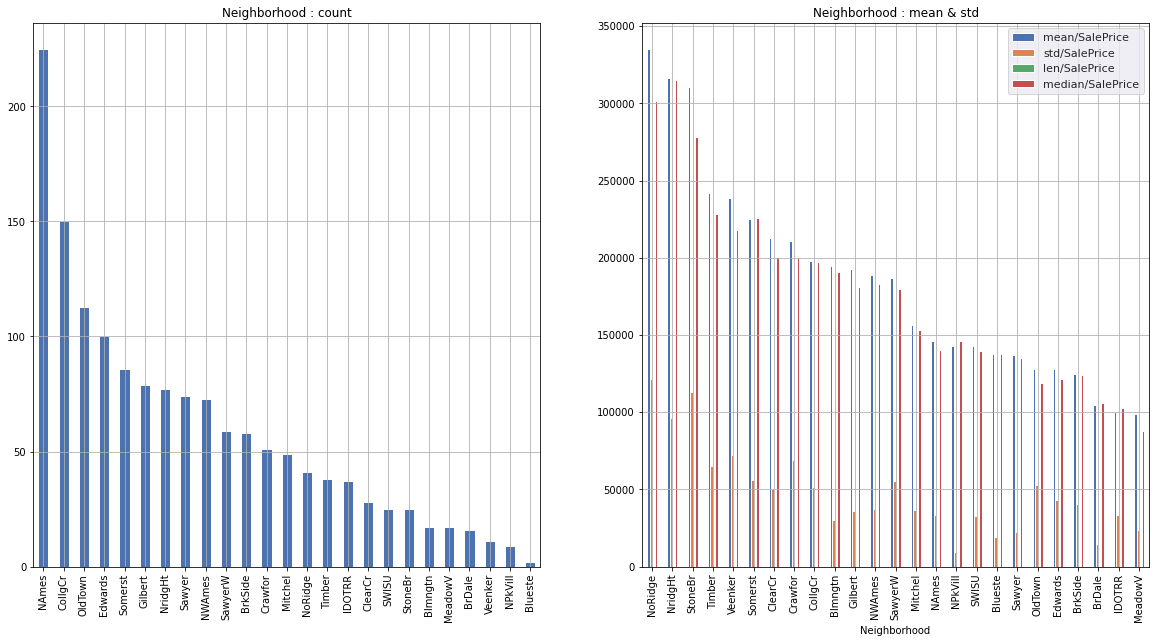

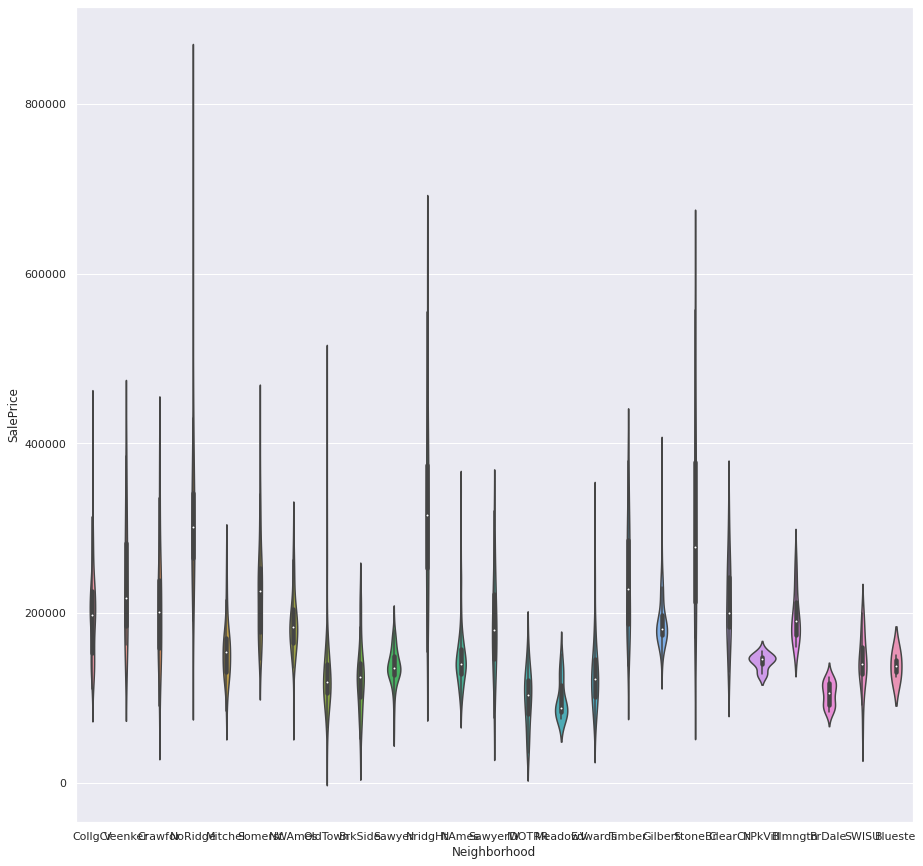

              mean/SalePrice  std/SalePrice  len/SalePrice  median/SalePrice
Neighborhood                                                                
NoRidge        335295.317073  121412.658640             41            301500
NridgHt        316270.623377   96392.544954             77            315000
StoneBr        310499.000000  112969.676640             25            278000
Timber         242247.447368   64845.651549             38            228475
Veenker        238772.727273   72369.317959             11            218000
Somerst        225379.837209   56177.555888             86            225500
ClearCr        212565.428571   50231.538993             28            200250
Crawfor        210624.725490   68866.395472             51            200624
CollgCr        197965.773333   51403.666438            150            197200
Blmngtn        194870.882353   30393.229219             17            191000
Gilbert        192854.506329   35986.779085             79            181000

In [ ]:
name = 'mean/SalePrice'

plotting_cat_Target('Neighborhood', name, True)

Voici Le type de plot qui peuvent apporter des informations interessantes sur les differentes variables et leur interaction avec le prix, cependant nous ne pouvons pas avec ce type de graphique comprendre l'interactions entre variables.

In [ ]:
plot_time(target, 'YrSold')

On peut ici aue l'immobilier a explose en 2007 pour atteindre sont minimum en 2008 (surement du au subprime)

In [ ]:
plot_time(target, 'YearRemodAdd')

On peut voir une augmentation plus ou moins exponentiel, on peut en deduire que plus l'annee de renovation est tardive plus le prix du bien immobilier est eleve

In [ ]:
plot_time(target, 'YearBuilt')

On peut voir ici qu'il y a deux grandes boss une en 1893 et en 2010 la derniere date du DataSet, un style de design vieux et un autre moderne

In [ ]:
plot_time(target, 'GarageYrBlt')

On peut voir pour la Contrustion de garage 3-4 pique de 1908 a 1934 significatif une periode de stagnation de 1936 a 1972 pour finir sur une montee exponnetionel

In [ ]:
corr = train_data_num.corr()
name_columns = corr.columns.to_list()
data = corr.to_numpy()

fig = px.imshow(data,
                labels=dict(x="Features", y="Features", color="Correlation"),
                x=name_columns,
                y=name_columns,
                width=1000, height=1000
              )

fig.update_xaxes(side="top")
fig.show()

Une connaissance metier des differentes variables serait l'ideale pour determiner et comprendre les relations entre les variables.

### Avertissement:
La correlation ne capte que les relations lineaires, de plus une correlation de 0 ne prouve en rien l'independance et une correlation forte en rien la causalite il peut y avoir par exemple un biais de confusion (une troisieme variable qui explique le lien entre les deux autres)

In [ ]:
multicolinearity_dectection(corr, 0.7)

[('OverallQual', 'SalePrice'),
 ('YearBuilt', 'GarageYrBlt'),
 ('TotalBsmtSF', '1stFlrSF'),
 ('GrLivArea', 'TotRmsAbvGrd'),
 ('GrLivArea', 'SalePrice'),
 ('GarageCars', 'GarageArea')]

### Pourquoi rechercher des correlation trop fortes :

Dans le fitting des models, la presence de variable trop correle entre elles peux causer des problemes, surtout pour la regression lineaire.
Les raisons sont qu'il n'y a pas de solution analytique du a la redondance des ligne/colonnes qui rend
 $X^{T}X$ car matrice singuliere pour la solution analytique $\beta =(X^{T}X)^{-1}XY$ et donc non inversible, instabilite du modeles, mauvaise estimation des valeurs des parametres en confondant les effet des features pour la prediction ce qui impliquera l'utilisation de norme L2.

#### Petites astuces :
Pour ceux qui aurait besoin d'une solution analytique malgres tout il y a une solution. <br> La forme analytique de L2 pour la regression ridge est la suivante $\beta =(X^{T}X + \lambda I)^{-1}XY$ ce distingue par $\lambda I$ si on utilise un $\lambda $ avec une faible valeur alors  $X^{T}X^{*} = (X^{T}X + \lambda I)^{-1}$ est inversible est peu differente de la solution de base

#### A savoir :
Pour ceux qui voudrais utiliser la regression lineaire ridge (Avec la penalisation L2) Sachez qu'elle penalise davantage les variables avec une variance faible (Voir [Element of Statistical learning](https://web.stanford.edu/~hastie/Papers/ESLII.pdf)) et donc par ce choix on suppose implicitement que les variables les plus informatives sont celles avec les variances les plus grandes, une hypothese raisonnable mais pas toujours vrai.


In [ ]:
x = corr.SalePrice.sort_values(ascending=True)
y = corr.SalePrice.sort_values(ascending=True).index

fig = go.Figure(data=[go.Bar(x=x, y=y, orientation='h')],
                layout=go.Layout(height=1000, width=1500))
# Customize aspect
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='Correlation avec SalePrice')
fig.show() 

On peut voir que les variables les plus explicatives lineairement sont :
- Overquall : La notation globale de la maison 
- GrLivArea : l'espace global de la maison 

De facon generale toutes variable lier a l'espace explique relativement bien la variable de prix

In [ ]:
train_data_cat.describe()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PavedDrive,YrSold,SaleType,SaleCondition
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379.0,1379,1379,1379,1460,1460,1460,1460
unique,5,2,4,4,2,5,3,25,9,8,5,8,112,61,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,97.0,3,5,5,3,5,9,6
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,2006,1950,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,2005.0,Unf,TA,TA,Y,2009,WD,Normal
freq,1151,1454,925,1311,1459,1052,1382,225,1260,1445,1220,726,67,178,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,65.0,605,1311,1326,1340,338,1267,1198


Ici nous allons essayer de Comprendre les differentes interraction les variables categorielles et la sortie, l'ideal serait d'avoir un avis metier pour savoir quelle variable faire interagir entre elles.

----- 

# Discretisation :
Ici nous allons discretiser la variable cible, cette discretisation va certe reduire la richesse contenu dans la distribution mais vas grandement faciliter l'intepretation de nos graphiques. 

### Avertissement pour les Lecteurs Stateux:
Une analyse de test Chi2 pour verifier l'independance est maintenant realisable,cependant dans le contexte Big Data (Pas le cas ici) les tests parametriques et non parametriques ne sont pas porteur de sens. les tests de type parametrique si le nombre d'elements et trop eleve, l'hypothese H0 ($\mu_{0}=\mu_{1}$) sera toujours rejeter car par exemple pour un test de student notre distribution H0 et notre distribution H1 vont tous les deux tendres vers uns distribution de Dirac, ce qui impliquera que meme une difference insignifiante sera vu comme une significatif, c'est une forme de sur-apprentissage. un point de vue bayesien n'est pas non plus une bonne option, premierement parce que l'ajout d'un apriori sera inutile si le nombre de donnees est trop eleve, il se fera ecraser par le maximum de vraisemblance et on reviendra au point de vue plus haut.
 
<br> Type de guassienne de base pour les tests: 

![Exemple](https://www.ilemaths.net/img/forum_img/0423/forum_423806_1.png)


<br>Gaussiennes => Dirac pour N >> 0: 

![Exemple](https://upload.wikimedia.org/wikipedia/commons/e/e6/Dirac_fonction.png)


Pour les tests non parametriques, ils faut garder a l'esprit que les modeles statiques pour ces test sont une simplification de la realite, le comportement de population de million d'individu peut etre difficilement modelise par deux ou trois parametre.

Une des solutions peut-etre de reechantillioner notre DataSet avec un Boostrap ou Jack-Knife (comme boostrap mais sans remise) et de faire nos tests, ici nous allons faire autrement.


In [27]:
Sale_Price_Discret = train_data.SalePrice.to_numpy().reshape(-1, 1)
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
discretizer.fit(Sale_Price_Discret)

Sale_Price_Discret = discretizer.transform(Sale_Price_Discret)

train_data['Sale_Price_Discret'] = Sale_Price_Discret

Plus ne nombre de bins sera faibles plus notre variable artificielle sera riche mais difficile a intepreter 

### Intepretation des graphes parallel_categories :

l'une des utilite de ce type de graphique et de pouvoir comprendre les differentes type d'interaction entre les variable categorielle, par exemple ci-dessus on peut commencer a comprendre les regles propres a notre jeux de donnees. <br> si le type de notre garage est Attachd (attache a notre maison ) et que notre garage est fini ( Fin	Finished, RFn	Rough Finished)	 les chances que sont prix soit grand est plus eleve. avec l'interaction des variables les plus interessantes on peut comprendre comment les variables est les combinaison de variables peuvent influer sur notre prix.

un autre possiblilite est de determiner rapidement les variables peu discriminante, si tous les "flux" converge vers une meme valeur on peut dire que c'est valeur est la seul discriminante et l'encoder en 1 pour cet etat est 0 pour les autres, ou comme dans notre exemple si une classe est trop majoritaire et que par consequent toute les flux converge vers cette classe, on peut deviner que le modele ne pourra pas detecter ce genre de signaux faible car trop rare et la supprimer.

et enfin si toutes les classes d'une variable ont une meme frequence de flux (valeur jaune, orange et  couleur en Frequence et pas nombre) c'est que la classe ne discrimine pas assez les variable car on a la meme probabilite d'etre haut dans un etat que dans un autre (penser au fonctionnement du test Chi2)

--------


### Caracterisque de garage :

In [ ]:
columns = ['GarageType',	'GarageFinish',	'GarageQual',	'GarageCond']

fig = px.parallel_categories(train_data, dimensions=columns,
                color="Sale_Price_Discret", color_continuous_scale=px.colors.sequential.Inferno)
fig.show()

### Caraterisque variable ordinal :

In [ ]:
columns = ['ExterQual', 'BsmtQual', 'BsmtCond','HeatingQC', 
           'KitchenQual', 'FireplaceQu', 'GarageQual','BsmtQual', ]

fig = px.parallel_categories(train_data, dimensions=columns,
                color="Sale_Price_Discret", color_continuous_scale=px.colors.sequential.Inferno)
fig.show()

### Le Reste

In [ ]:
columns = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 
           'LotConfig', 'MasVnrType', 'Foundation', 
           'CentralAir', 'Electrical', 'PavedDrive',	'YrSold', 'SaleType', 'SaleCondition']

fig = px.parallel_categories(train_data, dimensions=columns,
                color="Sale_Price_Discret", 
                color_continuous_scale=px.colors.sequential.Inferno)

fig.show() 

In [ ]:
columns = ['Neighborhood', 'BldgType', 'HouseStyle', 'LandSlope',
           'BldgType', 'Condition2', 'Condition1']

fig = px.parallel_categories(train_data, dimensions=columns,
                color="Sale_Price_Discret", color_continuous_scale=px.colors.sequential.Inferno)
fig.show()

Regle infere qui augmente les chance d'avoir un prix eleve : 
 - Garage : attacher a la maison ou faisant partie de la maison
 - Garage : fini ou rough finished
 - Garare : Qualite Moyenne (soit biaise du au manque de representabilite des classes/ soit distrution reel des classe et la majorite des appartement on une notation moyenne)
 - Garare : Condition Moyenne (soit biaise du au manque de representabilite des classes/ soit distrution reel des classe et la majorite des appartement on une notation moyenne)
 - ExterQual : (qualite des materiaux exterieur) : Bien ou excellent
 - BsmtQual : (Hauteur du sous-sol) : Excellente ou Bien
 - BsmtCond : (Evaluation global du sous-sol) : Moyen ou bien (soit biaise du au manque de representabilite des classes/ soit distrution reel des classe et la majorite des appartement on une notation moyenne)
 - Heating : Excelent > bien
 - KitchenQual : Excelent ou bien
 - FirePlace : Excellent, Bon, Moyen
 - GarageQual : Moyen (soit biaise du au manque de representabilite des classes/ soit distrution reel des classe et la majorite des appartement on une notation moyenne)
 - MSZoning : Residence a faible densite ou residence a faible densite
 - Street Pave 
 - LotShape : (Forme generale de la propriete) Regulier, ou legerement/moderement irreguliere
 -  LandContour : Plat ou Hillside (Flanc de couteau)
 -  Utilities : AllPub (tous les utilitaires Majoritaire des cas ce qui semble logique)
 - LotConfig : inside, Corner, Cul-de-sac
 - MasVnrType (Type de masonnerie) : Pierre > Brique de Face 
 - Foundation : Beton coule > Parpaing
 - CentralAir : Oui (Logique)
 - Electricite : SBrkr	Standard Circuit Breakers & Romex
 - PavedDrive (Route pave) : Y (oui)
 - YrSold : sensiblement les meme (l'annee de vente influe peu sur la vente)
 - SaleType : New > WD(Warranty Deed - Conventional = Acte de garantie
)
 - SaleCondition : Partial > Normal
 - Neiborhood : NridgHt	Northridge Heights (Lincoln), StoneBr	Stone Brook (New York), NoRidge	Northridge(Los angeles) > CollgCr	College Creek (Virginie),  Crawfor (Colorado), Gilbert(Arizona), Timberland (Wisconsin), Clear Creek (Oklahoma)
 - BldgType(Type de voisinnage) : une famille detache > Townhouse End Unit
 - HouseStyle : 2Story > 1Story
 - LandSlope : Gtl (Gentle slope : Pente Douce) > Mod > Sev
 - Condition1&2 : Norm


------ 

### Comprehension de La donnees :
- Pour une meilleur comprehension de la donnees il n'est pas suffisant de s'arreter a la il faut dans la majorite des cas demander au metier ou a internet pour savoir si nos intepretation de la donnees est bonne ou non.

----- 

### Interraction des variables Numerique PCA : 

Nous allons ici nous interreser a la PCA (ACP - analyse en composante principale).

L'ACP  est un outil qui nous permet de reduire le nombre de dimension cela nous offre plusieurs possibilite : 
- Voir visuelement comment se comporte nos points et variables
- Reduire le cout de l'espace memoire et temporelle si un gros jeu de donnees (pas le cas ici)
- Supprime le probleme de multicolinearite
- Evite le Fleau des dimensions

On a parler plutot du probleme du probleme de multicolinearite, mais qu'est que le fleau de dimension ? <br>
Quand le nombre de features grandi il se passe une chose etrange,
nos points ont tendance a ce concentrer sur la bordure de notre espace, une analogie du livre [Data Science : fondamentaux et études de cas: Machine Learning avec Python et R](https://www.amazon.fr/Data-science-fondamentaux-Machine-Learning/dp/2212142439) fais reference a une orange, tout les points se concentrerais sur la peau et en plus de cela les point serai eparse (isole et donc loin les uns des autres) et voila le debut des problemes...

Regression : Plusieurs configuration du meme modele peuvent donnees la meme erreur (explicabilite) cela peut sembler etre une bonne nouvelle mais non, cela reviens a dire que nos modeles sont totalement instable et ne comprennent pas le phenomene ne peuvent donc pas generaliser et donc une erreur sur le test peut sera catastrophique par ailleurs si le nombre de dimension est superieur au nombre d'exemple on peut "expliquer" notre phenomene par une infinite de configuration...

Classification : Etant donnee que les donnees sont trop loin les une des autre trouver un hyperplan (Grossieremment un plan avec N-1 features) est de l'ordre de l'impossible ou rendra un tres mauvais resultat sur le test

Clusteur & Estimateur d'estimation (KNN/k-means/Gmm) : Les methodes d'estimation sont locale c'est a dire qu'elle regarde a un voisinage et par la suite renvoye un reponse (Classe (Voting), Moyenne ou Parametre) le probleme c'est que comme les points sont eparses la detections de ce voisinage est beaucoup plus couteux est complexe car on peut par avoir besoin de 80% de l'espace, ce n'est plus une methode locale.

une solution peut etre de trouver de nouvelles donnees, ce qui peut s'averer chere... voir impossible.

un autre est d'utiliser la norme 1 piur la regression lineare on parlera de regression Lasso.

### Norme est regularisation:

Les norme sont des outils mathematique qui permete de definir des distance. 
Dans le machine learning ils servent a penaliser les poids inferer de maniere brutale (L1) ou plus douce (L2)

Nous ne detaillerons pas ici les detailles mathematique mais plus l'intuition de leur effet 

![alt text](https://i.stack.imgur.com/oVJDB.png)

A gauche on a la la norme L1 et a gauche L2. <br> <br> La zone bleu decris les possibles (sa Topologie)  des normes et en rouge les valeurs possibles de nos parametres, la solution de se trouve a l'intersection des zone bleu et rouge, pour faire simple la regularisation vas forcer nos parametres a avoir des variable proches de 0.

pour la norme L1 on a un losange on peut voir une chose interessantes l.intersection (et donc la solution) est $\beta_{1} = 0$ et $\beta_{2} = 1 $

si nous etions dans le cas d'une regression nous aurions $Y=\beta_{1}X_{1} + \beta_{2}X_{2} $ et en remplacant les valeurs de $\beta$ on obtient $Y = X_{2}$
On a supprimer une Variable ! D'ou l'utilisation de la Norme L1 pour la selection de variables.

#### Pour la culture : 

Quand la norme tant vers 0 on la topologie de cette derniere s'aplatie comme l'image ci-dessous

![alt text](https://miro.medium.com/max/552/1*QGBBctIIxyX2FPBgh1MphA.png)
Quand la norm

In [28]:
train_data_num = train_data.select_dtypes(exclude='object')

num_pipeline_PCA = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('StandardScaler', StandardScaler())
    ])

train_data_PCA = num_pipeline_PCA.fit_transform(train_data_num.drop([target], axis=1))

from sklearn.decomposition import PCA 
import plotly.offline as py


sklearn_pca = PCA(n_components=2)
X_PCA = sklearn_pca.fit_transform(train_data_PCA)

In [31]:
data = []
Target = train_data_num.Sale_Price_Discret


fig = go.Figure(data=go.Scattergl(
    x = X_PCA[:,0],
    y = X_PCA[:,1],
    mode='markers',
    marker=dict(
        color=Target,
        colorscale='Viridis',
        line_width=1
    )
))

fig.show()


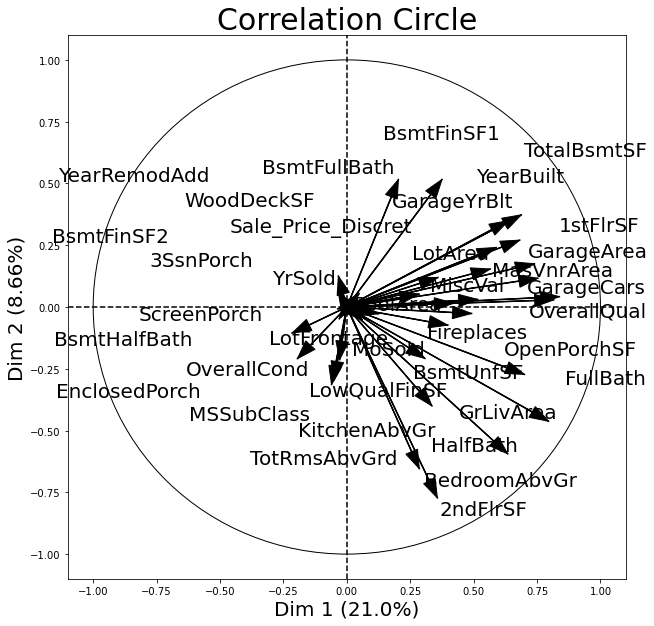

In [ ]:
X_norm = train_data_PCA

feature_names = train_data_num.drop([target], axis=1).columns.to_list()

figure, correlation_matrix = plot_pca_correlation_graph(X_norm, 
                                                        feature_names,
                                                        dimensions=(1, 2),
                                                        figure_axis_size=10)

In [ ]:
sklearn_pca.explained_variance_ratio_

array([0.21069289, 0.08662542])

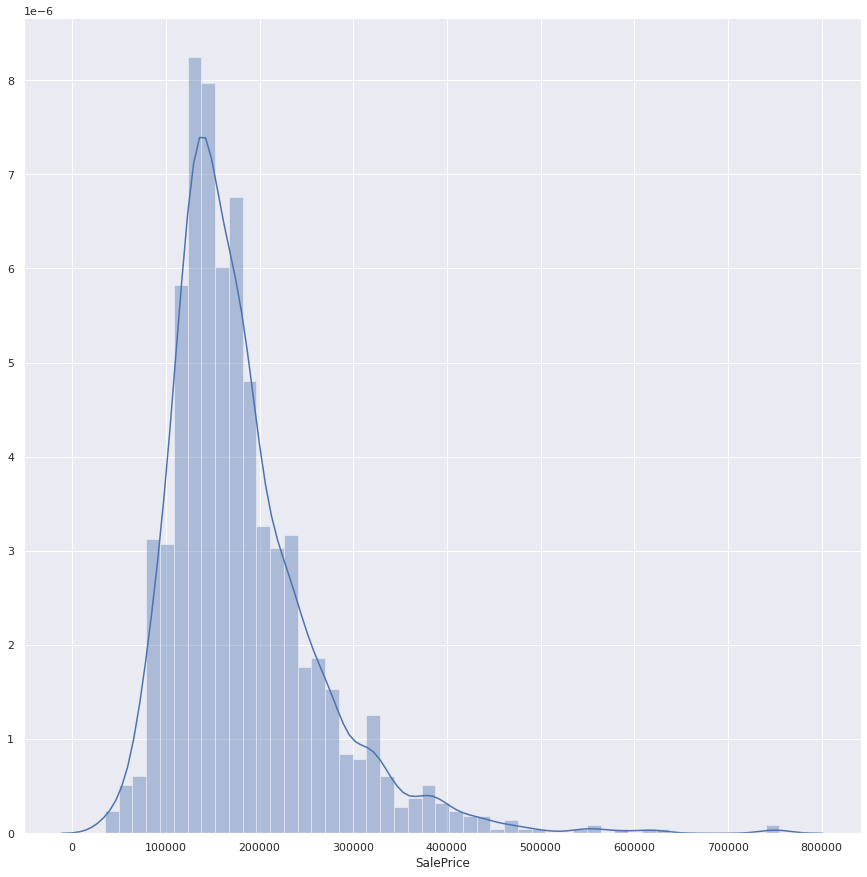

In [ ]:
x = train_data_num.SalePrice
ax = sns.distplot(x )

In [ ]:
train_data_num.SalePrice.describe()

In [ ]:
columns_num = [w for w in corr.SalePrice.sort_values(ascending=False).index if w != target and w.lower() != 'id']

for col in columns_num: plotting_num_dist(col, train_data_num) 

In [ ]:
for col in columns_num:  plotting_num_join(col, train_data_num) 

In [ ]:
train_data_num = train_data_clean.select_dtypes(exclude='object')
train_data_cat = train_data_clean.select_dtypes(include='object')

num_attribs = train_data_num.drop(target, axis=1).columns.to_list()
cat_attribs = train_data_cat.columns.to_list()

train_data[cat_attribs] = train_data[cat_attribs].apply(lambda x: x.fillna(x.value_counts().index[0]))

train_data_cat_dummies = pd.get_dummies(train_data[cat_attribs])
train_data_dummies = pd.concat([train_data_num.drop(target, axis=1), train_data_cat_dummies], axis=1)



num_pipeline_tree = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
    ])

train_data_dummies_scaled = train_data_dummies

train_data_num_np_tree = num_pipeline_tree.fit_transform(train_data_num.drop(target, axis=1))
train_data_dummies[num_attribs] = train_data_num_np_tree
X = train_data_dummies

Y = train_data[target]


In [ ]:
train_X, val_X, train_y, val_y = train_test_split(X, Y, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=3, min_samples_split=2, criterion="entropy").fit(train_X, train_y)

feature_names = X.columns.to_list()
tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=feature_names, max_depth=2)
graphviz.Source(tree_graph)

In [ ]:
from sklearn.ensemble import RandomForestClassifier


figsize=(20,20)
sns.set(rc={'figure.figsize':figsize})

RF_clf = RandomForestClassifier(max_depth=2, random_state=0)
RF_clf.fit(X, Y)

df_features = pd.DataFrame(train_data_dummies.columns, RF_clf.feature_importances_).reset_index() 
df_features.columns = ['Features_importance', 'Features']
df_features = df_features.sort_values(by='Features_importance', ascending=False)
df_features = df_features.query('Features_importance > 0')

ax = sns.barplot(x="Features_importance", y="Features", data=df_features)

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(X, Y, random_state=1)
my_model = RandomForestClassifier(n_estimators=100,
                                  random_state=0).fit(train_X, train_y)


perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

In [ ]:
corr = X.corr()
multicolinearity_dectection(corr, 0.75)

In [ ]:
drop_multicolinearity = ['GarageYrBlt', 'HouseStyle_2Story', 'Neighborhood_Somerst']

X = X.drop(drop_multicolinearity, axis=1)

In [ ]:
cross_val_score(my_model, X, Y, n_jobs=-1, cv=3, scoring='r2')

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from collections import OrderedDict


SPACE = {
    'learning_rate': hp.uniform('learning_rate', 0.05, 0.2),
    'max_depth': hp.choice('max_depth', range(2, 10, 1)),
    'feature_fraction': hp.uniform('feature_fraction', 0.01, 1.0),
    'num_iterations': 1000,
    'boosting': hp.choice('boosting', ['gbdt', 'dart']),
    'max_bin': hp.choice('max_bin', range(2, 10)),
    'num_leaves': hp.choice('num_leaves', range(2, 10)),
    'lambda_l1': hp.uniform('lambda_l1', 0.0, 1.0),
    'lambda_l2': hp.uniform('lambda_l2', 0.0, 1.0),
    'min_gain_to_split': hp.uniform('min_gain_to_split', 0.0, 1.0),
    }

def f(params: Dict):
    R2 = hyperopt_train_test(params, X, Y)
    return {'loss': R2, 'status': STATUS_OK}

trials = Trials()


def find_best_param(f, SPACE: Dict, trials) -> Dict:
  best = fmin(f, SPACE, algo=tpe.suggest, 
                max_evals=50, trials=trials)
  return best



In [ ]:
best = find_best_param(f, SPACE, trials)

best['boosting'] = 'gbdt' if best['boosting'] == 0 else 'dart'
model = lgb.LGBMRegressor(**best)

In [ ]:
model.fit(X, Y)

cross_val_score(model, X, Y, n_jobs=-1, cv=5, scoring='r2').mean()

In [ ]:
lightgbm.plot_importance(model)

In [ ]:
fetures_importance_lgbm = [(i, j) for i, j in zip(model.feature_importances_, X.columns)]
fetures_importance_lgbm = sorted(fetures_importance_lgbm, key=lambda x: x[0], reverse=True)
fetures_importance_lgbm_name = [x[1] for x in fetures_importance_lgbm if x[0] > 0]

In [ ]:
X_selected_var_lgbm = X[fetures_importance_lgbm_name]

In [ ]:
def f(params):
    R2 = hyperopt_train_test(params, X_selected_var_lgbm, Y)
    return {'loss': R2, 'status': STATUS_OK}

trials = Trials()

best = fmin(f, SPACE, algo=tpe.suggest, 
              max_evals=10, trials=trials)

In [ ]:
best['boosting'] = 'gbdt' if best['boosting']== 0 else 'dart'
model = lgb.LGBMRegressor(**best)

cross_val_score(model, X_selected_var_lgbm, Y, n_jobs=-1, cv=5, scoring='r2').mean()

In [ ]:
model.fit(X_selected_var_lgbm, Y)

lightgbm.plot_importance(model)

In [ ]:
permutation_importance = PermutationImportance(model, random_state=1)
permutation_importance.fit(X_selected_var_lgbm, Y)

display(eli5.show_weights(permutation_importance, feature_names = X_selected_var_lgbm.columns.to_list()))

In [ ]:
shap_values = shap.TreeExplainer(model).shap_values(X_selected_var_lgbm)
shap.summary_plot(shap_values, X_selected_var_lgbm, plot_type="bar")

In [ ]:
import matplotlib.pyplot as plt

f = plt.figure()
shap.summary_plot(shap_values, X_selected_var_lgbm)

In [ ]:
X_selected_var_lgbm

shap.dependence_plot("OverallQual", shap_values, X_selected_var_lgbm)

In [ ]:
shap.dependence_plot("GrLivArea", shap_values, X_selected_var_lgbm)

In [ ]:
shap.dependence_plot("TotalBsmtSF", shap_values, X_selected_var_lgbm)

# ML Avec Features engineering 

In [ ]:
col_drop = ['MiscFeature', 'Fence', 'PoolQC']


train_feature_engineering = train_data.drop(col_drop, axis=1)


Var_ordinal = ['ExterQual', 
               'ExterCond', 'BsmtQual', 'BsmtCond', 
               'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
               'HeatingQC', 'CentralAir', 'KitchenQual', 'FireplaceQu',
               'GarageQual', 'GarageCond']

In [ ]:
dict_ordinal = {
    'ExterQual' : 
    {
        'Ex': 5, 
        'Gd': 4,
        'TA': 3,
        'Fa': 2,
        'Po': 1,
        'Vide': 0},

    'ExterCond':
    {
        'Ex': 5,
        'Gd': 4,
        'TA': 3,
        'Fa':	2,
        'Po': 1,
        'Vide': 0
    },
    'BsmtQual':
    {
         'Ex':	5,
         'Gd':	4,
         'TA':	3,
         'Fa':	2,
         'Po':	1,
         'NA':	0,
         'Vide': 0
    },

    'BsmtCond':
    {
         'Ex':	5,
         'Gd':	4,
         'TA':	3,
         'Fa':	2,
         'Po':	1,
         'NA':	0,
         'Vide': 0
    },
     
    'BsmtExposure':
    {
         'Gd':	4,
         'Av':	3,
         'Mn':	2,
         'No':	1,
         'NA':	0,
         'Vide': 0
    },

    'BsmtFinType1':
    {
         'GLQ':	6,
         'ALQ':	5,
         'BLQ':	4,
         'Rec':	3,
         'LwQ':	2,
         'Unf': 1,
         'NA': 0,
         'Vide': 0
    },
     
    'BsmtFinType2':
    {
         'GLQ':	6,
         'ALQ':	5,
         'BLQ':	4,
         'Rec':	3,
         'LwQ':	2,
         'Unf': 1,
         'NA': 0,
         'Vide': 0
    },
    
    'HeatingQC':
    {
         'Ex':	5,
         'Gd':	4,
         'TA':	3,
         'Fa':	2,
         'Po':	1,
         'Vide': 0
    },


    'CentralAir':
    {
         'N':	0,
         'Y':	1,
         'Vide': 0
    },

    'KitchenQual':
    {
         'Ex':	5,
         'Gd':	4,
         'TA':	3,
         'Fa':	2,
         'Po':	1,
         'Vide': 0
    },

    'FireplaceQu':
    {
         'Ex':	5,
         'Gd':	4,
         'TA':	3,
         'Fa':	2,
         'Po':	1,
         'NA':	0,
         'Vide': 0
    },

    'GarageQual':
    {
         'Ex':	5,
         'Gd':	4,
         'TA':	3,
         'Fa':	2,
         'Po':	1,
         'NA':	0,
         'Vide': 0
    },

    'GarageCond':
    {
         'Ex':	5,
         'Gd':	4,
         'TA':	3,
         'Fa':	2,
         'Po':	1,
         'NA':	0,
         'Vide': 0
    }

}

In [ ]:
train_feature_engineering[Var_ordinal] = train_feature_engineering[Var_ordinal].fillna('Vide')

for col in Var_ordinal: train_feature_engineering[col] = train_feature_engineering[col].apply(lambda x: dict_ordinal[col][x] 
                                        if x in dict_ordinal[col].keys()
                                        else -1)

train_feature_engineering['Global_rate'] = 0

for col in Var_ordinal: train_feature_engineering['Global_rate'] += train_feature_engineering[col]

In [ ]:
train_feature_engineering['Global_rate'].plot.kde(figsize=(10, 10))

In [ ]:
train_feature_engineering.corr().SalePrice.sort_values(ascending=True).plot.barh()

In [ ]:
var_cat_not_ordinal = train_feature_engineering.select_dtypes(include='object').columns.to_list()


train_feature_engineering[var_cat_not_ordinal] = train_feature_engineering[var_cat_not_ordinal].fillna('Vide')

dict_feature_engineering_cat = {}
for col in var_cat_not_ordinal:
  dict_temp = {}
  keys = train_feature_engineering[col].value_counts().index.to_list()
  dict_test = train_feature_engineering.pivot_table(values=target, index=col, aggfunc=['mean', 'std']).to_dict()
  for value in keys:
    new_value = dict_test[('mean', target)][value] / dict_test[('std', target)][value] 
    dict_temp[value] = 0 if np.isnan(new_value) else new_value

  dict_feature_engineering_cat[col] = dict_temp


In [ ]:
for col in var_cat_not_ordinal: train_feature_engineering[col] = train_feature_engineering[col].apply(lambda x: dict_feature_engineering_cat[col][x])

In [ ]:
'''g = sns.pairplot(train_feature_engineering.sample(1000), kind="reg", corner=True)'''

In [ ]:
var_cat = Var_ordinal + var_cat_not_ordinal

train_feature_engineering['Global_Var_Cat_Rate'] = 0

for col in var_cat: train_feature_engineering['Global_Var_Cat_Rate'] += train_feature_engineering[col]

In [ ]:
train_feature_engineering.corr().SalePrice.sort_values(ascending=True).plot.barh(figsize=(10, 20))

In [ ]:
g = sns.jointplot("Global_Var_Cat_Rate", "SalePrice", data=train_feature_engineering, kind="reg", size=10)

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(X, Y, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=3, min_samples_split=2, criterion="entropy").fit(train_X, train_y)

feature_names = X.columns.to_list()
tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=feature_names, max_depth=2)
graphviz.Source(tree_graph)

In [ ]:
figsize=(20,20)
sns.set(rc={'figure.figsize':figsize})

RF_clf = RandomForestClassifier(max_depth=2, random_state=0)
RF_clf.fit(X, Y)

df_features = pd.DataFrame(X.columns, RF_clf.feature_importances_).reset_index() 
df_features.columns = ['Features_importance', 'Features']
df_features = df_features.sort_values(by='Features_importance', ascending=False)
df_features = df_features.query('Features_importance > 0')

ax = sns.barplot(x="Features_importance", y="Features", data=df_features)

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(X, Y, random_state=1)
my_model = RandomForestClassifier(n_estimators=100,
                                  random_state=0).fit(train_X, train_y)

cross_val_score(my_model, X, Y, n_jobs=-1, cv=3, scoring='r2').mean()

In [ ]:
SPACE = {
    'learning_rate': hp.uniform('learning_rate', 0.05, 0.2),
    'max_depth': hp.choice('max_depth', range(2, 10, 1)),
    'feature_fraction': hp.uniform('feature_fraction', 0.01, 1.0),
    'num_iterations': 1000,
    'boosting': hp.choice('boosting', ['gbdt', 'dart']),
    'max_bin': hp.choice('max_bin', range(2, 10)),
    'num_leaves': hp.choice('num_leaves', range(2, 10)),
    'lambda_l1': hp.uniform('lambda_l1', 0.0, 1.0),
    'lambda_l2': hp.uniform('lambda_l2', 0.0, 1.0),
    'min_gain_to_split': hp.uniform('min_gain_to_split', 0.0, 1.0),
    }

def f(params: Dict):
    R2 = hyperopt_train_test(params, X, Y)
    return {'loss': R2, 'status': STATUS_OK}

trials = Trials()


def find_best_param(f, SPACE: Dict, trials) -> Dict:
  best = fmin(f, SPACE, algo=tpe.suggest, 
                max_evals=50, trials=trials)
  return best

best = find_best_param(f, SPACE, trials)

best['boosting'] = 'gbdt' if best['boosting'] == 0 else 'dart'
model = lgb.LGBMRegressor(**best)

In [ ]:
best['boosting'] = 'gbdt' if best['boosting']== 0 else 'dart'
model = lgb.LGBMRegressor(**best)

cross_val_score(model, X, Y, n_jobs=-1, cv=5, scoring='r2').mean()

In [ ]:
g = sns.jointplot("Fireplaces", target, data=train_feature_engineering, kind="reg", size=10)

In [ ]:
'''g = sns.jointplot("FireplaceQu", target, data=train_feature_engineering, kind="reg", size=10)'''

In [ ]:
train_feature_engineering['Available_Basement'] =\
train_feature_engineering['TotalBsmtSF'] - train_feature_engineering['BsmtUnfSF']

train_feature_engineering['Available_square_floor'] =\
train_feature_engineering['1stFlrSF'] + train_feature_engineering['2ndFlrSF']

train_feature_engineering['Global_area'] =\
train_feature_engineering['GarageArea'] + train_feature_engineering['WoodDeckSF'] +\
train_feature_engineering['OpenPorchSF'] + train_feature_engineering['EnclosedPorch'] +\
train_feature_engineering['3SsnPorch'] + train_feature_engineering['ScreenPorch'] +\
train_feature_engineering['PoolArea'] + train_feature_engineering['Avalable_Basement'] +\
train_feature_engineering['1stFlrSF'] + train_feature_engineering['2ndFlrSF'] + train_feature_engineering['GrLivArea']


def time_before_sale(build, remodeling, sold):
  if remodeling == 0: return abs(build - sold)
  else: return abs(remodeling - sold)

build = train_feature_engineering['YearBuilt']
remodeling = train_feature_engineering['YearRemodAdd']
sold = train_feature_engineering['YrSold'] 

train_feature_engineering['TimeBeforeSale'] = list(map(time_before_sale, 
                                                       build, remodeling,
                                                       sold))

In [ ]:
def define_X_Y_sklearn(data: pd.DataFrame, target:str) -> Tuple[pd.DataFrame, pd.Series]:
  num_pipeline_tree = Pipeline([
          ('imputer', SimpleImputer(strategy="median")),
      ])


  X = num_pipeline_tree.fit_transform(data.drop(target, axis=1))
  X = pd.DataFrame(X, columns=data.drop(target, axis=1).columns)
  Y = data[target]

  return X, Y

X, Y = define_X_Y_sklearn(train_feature_engineering, target)

In [ ]:
corr = X.corr()
multicolinearity_dectection(corr, 0.75)

In [ ]:
SPACE = {
    'learning_rate': hp.uniform('learning_rate', 0.05, 0.2),
    'max_depth': hp.choice('max_depth', range(2, 10, 1)),
    'feature_fraction': hp.uniform('feature_fraction', 0.01, 1.0),
    'num_iterations': 1000,
    'boosting': hp.choice('boosting', ['gbdt', 'dart']),
    'max_bin': hp.choice('max_bin', range(2, 10)),
    'num_leaves': hp.choice('num_leaves', range(2, 10)),
    'lambda_l1': hp.uniform('lambda_l1', 0.0, 1.0),
    'lambda_l2': hp.uniform('lambda_l2', 0.0, 1.0),
    'min_gain_to_split': hp.uniform('min_gain_to_split', 0.0, 1.0),
    }


trials = Trials()


best = find_best_param(f, SPACE, trials)

best['boosting'] = 'gbdt' if best['boosting'] == 0 else 'dart'
model = lgb.LGBMRegressor(**best)

In [ ]:
best['boosting'] = 'gbdt' if best['boosting']== 0 else 'dart'
model = lgb.LGBMRegressor(**best)

cross_val_score(model, X, Y, n_jobs=-1, cv=5, scoring='r2').mean()

In [ ]:
best

In [ ]:
model.fit(X, Y)

lightgbm.plot_importance(model)